# Premier workflow d'identication d'un champignon
Utilisation d'un générateur d'images  
Fichiers en local sur le HDD dont les emplacements sont dans un dataset à télécharger ici: (Ca devient gros, disponible sur demande par ftp)
Utilisation d'un modèle pré-entrainé VGG16

Pour ce test, nous avons sélectionné les 10 genres de champignons suivants:
Paxillus, Clathrus, Geastrum, Scleroderma, Byssomerulius, Phaeolus, Agaricus, Amanita, Auricularia, Craterellus
  
Voici le lien pour télécharger les images : 

Puis dézipper le fichier au même niveau que le notebook, de sorte que le notebook et le répertoire Images soient au même niveau


In [1]:
import os 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

## Chargement du csv contenant les chemins des images à utiliser sur le HDD
4000 liens url par classes  
Séparation jeu d'entrainement et de test à 20%

In [2]:
import pandas as pd
import pathlib

# Chargement du fichier
df = pd.read_csv ("allpath.csv")

#Création d'une nouvelle variable contenant l'arborescence sur le HDD des fichiers images
df["path"] = '/'+df["order"]+'/'+df["family"]+'/'+df["genus"]+'/'+df["species"]+'/'+'im'+df.index.astype('str')+".jpg"

# On ajoute le chemin où se trouve l'arborescence précédente (peut varier selon les personnes)
base_dir = './ChampImages'
df["path"] = base_dir+df["path"]

# On élimine les images en provenance de http:\\sweetgum.nybg.org (cf. rapport) 
df["isweetgum"]=df["identifier_y"].apply(lambda x: "sweetgum.nybg.org" in x)
df = df[df["isweetgum"]== False]


In [3]:
df.head()

,Unnamed: 0,id,identifier_y,kingdom,phylum,class,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,isweetgum
0,0,2438770494,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Hygrophoraceae,Hygrocybe,Hygrocybe hypospoda,Hygrocybe hypospoda,AU,-39.020600,146.336100,True,./ChampImages/Agaricales/Hygrophoraceae/Hygroc...,False
1,1,2438770494,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Hygrophoraceae,Hygrocybe,Hygrocybe hypospoda,Hygrocybe hypospoda,AU,-39.020600,146.336100,True,./ChampImages/Agaricales/Hygrophoraceae/Hygroc...,False
2,2,2434842541,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Mycenaceae,Mycena,Mycena mulawaestris,Mycena mulawaestris,AU,-37.666667,145.733333,True,./ChampImages/Agaricales/Mycenaceae/Mycena/Myc...,False
3,3,2435361192,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Russulales,Bondarzewiaceae,Amylosporus,Amylosporus campbellii,Amylosporus campbellii,MM,NaN,NaN,False,./ChampImages/Russulales/Bondarzewiaceae/Amylo...,False
4,4,2438837736,https://images.ala.org.au/image/proxyImageThum...,Fungi,Basidiomycota,Agaricomycetes,Agaricales,Agaricaceae,Barcheria,Barcheria willisiana,Barcheria willisiana,AU,-32.176100,121.399700,True,./ChampImages/Agaricales/Agaricaceae/Barcheria...,False


## On limite notre test à 10 classes et 4000 photos par classes
On augmentera encore la semaine prochaine

In [4]:
sample_per_classe = 4000

sub_c1 = df[df["genus"] == "Paxillus"].sample(sample_per_classe)
sub_c2 = df[df["genus"] == "Clathrus"].sample(sample_per_classe)
sub_c3 = df[df["genus"] == "Geastrum"].sample(sample_per_classe)
sub_c4 = df[df["genus"] == "Scleroderma"].sample(sample_per_classe)
sub_c5 = df[df["genus"] == "Byssomerulius"].sample(sample_per_classe)
sub_c6 = df[df["genus"] == "Phaeolus"].sample(sample_per_classe)
sub_c7 = df[df["genus"] == "Agaricus"].sample(sample_per_classe)
sub_c8 = df[df["genus"] == "Amanita"].sample(sample_per_classe)
sub_c9 = df[df["genus"] == "Auricularia"].sample(sample_per_classe)
sub_c10 = df[df["genus"] == "Craterellus"].sample(sample_per_classe)

data = pd.concat([sub_c1, sub_c2, sub_c3, sub_c4, sub_c5, sub_c6, sub_c7, sub_c8, sub_c9, sub_c10])

data

,Unnamed: 0,id,identifier_y,kingdom,phylum,class,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,isweetgum
535649,560407,2429611422,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,FI,61.771083,23.100578,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
699532,731550,2981501368,https://www.artsobservasjoner.no/MediaLibrary/...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus filamentosus,Paxillus filamentosus,NO,59.741970,10.751109,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
2001411,2134574,2898635390,https://svampe.databasen.org/uploads/2020-1013...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus (Batsch) Fr.,DK,55.965921,10.135918,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
212986,226866,3330785332,https://static.inaturalist.org/photos/49396470...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,DK,55.484081,9.417291,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
1506976,1606918,2634119859,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,RU,57.190241,85.817773,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1257157,1337890,1990332020,https://mycoportal.org/tenn/mycology/00060/TEN...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus venosus,Craterellus venosus,US,35.560278,-83.178889,True,./ChampImages/Cantharellales/Cantharellaceae/C...,False
554349,579591,2860921398,https://www.artsobservasjoner.no/MediaLibrary/...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus tubaeformis,Craterellus tubaeformis,NO,59.203497,9.321360,True,./ChampImages/Cantharellales/Cantharellaceae/C...,False
317170,334546,3335562562,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus tubaeformis,Craterellus tubaeformis,FR,42.796950,-0.555436,True,./ChampImages/Cantharellales/Cantharellaceae/C...,False
333473,351396,2868209412,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Cantharellales,Cantharellaceae,Craterellus,Craterellus fallax,Craterellus fallax,US,38.932317,-77.090211,True,./ChampImages/Cantharellales/Cantharellaceae/C...,False


## Création des ensembles d'entrainement et de test

In [5]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, test_size = 0.2)

data.head()

,Unnamed: 0,id,identifier_y,kingdom,phylum,class,order,family,genus,species,verbatimScientificName,countryCode,decimalLatitude,decimalLongitude,hasCoordinate,path,isweetgum
535649,560407,2429611422,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,FI,61.771083,23.100578,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
699532,731550,2981501368,https://www.artsobservasjoner.no/MediaLibrary/...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus filamentosus,Paxillus filamentosus,NO,59.741970,10.751109,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
2001411,2134574,2898635390,https://svampe.databasen.org/uploads/2020-1013...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus (Batsch) Fr.,DK,55.965921,10.135918,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
212986,226866,3330785332,https://static.inaturalist.org/photos/49396470...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,DK,55.484081,9.417291,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False
1506976,1606918,2634119859,https://inaturalist-open-data.s3.amazonaws.com...,Fungi,Basidiomycota,Agaricomycetes,Boletales,Paxillaceae,Paxillus,Paxillus involutus,Paxillus involutus,RU,57.190241,85.817773,True,./ChampImages/Boletales/Paxillaceae/Paxillus/P...,False


## Test d'affichage de la première image du Data_Test 

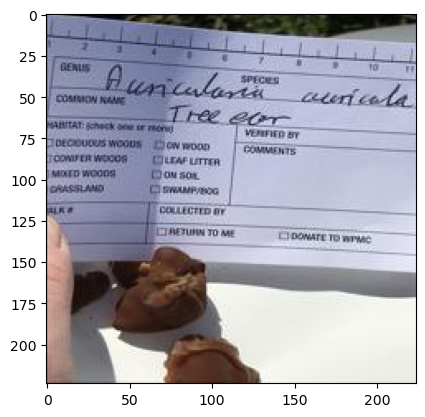

In [6]:
from tensorflow.keras.preprocessing import image

filename = data_test.path.iloc[0]

# A conserver pour d'autres tests rapides
#img = image.load_img('./Images/test/Agaricaceae/Chlorophyllum brunneum1866.jpg',target_size=(224,224))

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

## Générateur d'image
On met rotation_range à 180 pour générer des images dans tous les sens, ce qui devrait permettre d'éviter le flip (à valider)  


In [7]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# Parametres du générateur d'images pour l'entrainement
train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 180,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   brightness_range = [0.9,1.1],
                                   horizontal_flip = False)

# Générateur d'images pour le test
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [12]:
# Entrainment depuis des images données dans un dataset
batch_size = 20
train_generator = train_datagen.flow_from_dataframe(dataframe=data_train,
                                                    directory = "",
                                                    x_col = "path",
                                                    y_col = "genus",
                                                    batch_size = batch_size,
                                                    class_mode = 'sparse', #"raw", #"'binary', #'sparse' ?
                                                    target_size = (224, 224))

# Validation avec les images de test sur le HDD
validation_generator = test_datagen.flow_from_dataframe(dataframe=data_test,
                                                        directory="",
                                                        x_col = "path",
                                                        y_col = "genus",
                                                        batch_size = batch_size,
                                                        class_mode = 'sparse',
                                                        target_size = (224, 224))

C:\Users\bhozj\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 11276 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 20724 validated image filenames belonging to 10 classes.
Found 5166 validated image filenames belonging to 10 classes.


C:\Users\bhozj\anaconda3\envs\tf-gpu\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 2834 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


## Elimination des fichiers corrompus sur le HDD
Nous avons pu constater que des fichiers corrompus faisaient planter les modèles 

In [13]:
from PIL import Image
tab = train_generator.filenames
for i in tab:
    try:
        Image.open(i)

    except:
        print('Error occur on ' + i)
        os.remove(i)
        
tab = validation_generator.filenames
for i in tab:
    try:
        Image.open(i)

    except:
        print('Error occur on ' + i)
        os.remove(i)

## Création du modèle VGG16 pré-entrainé avec ImageNet

In [14]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import Sequential

base_model = VGG16(input_shape=(224, 224,3), 
                      include_top=False, 
                      weights="imagenet")

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units = 10, activation = 'softmax'))

model.compile(optimizer = "adam", #optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), 
                   loss = 'sparse_categorical_crossentropy', #loss = 'binary_crossentropy', 
                   metrics = ['acc'])


## Entrainement

In [15]:
history = model.fit(train_generator, 
                         validation_data = validation_generator, 
                         steps_per_epoch = len(data_train) // batch_size // 2,
                         validation_steps= len(data_test) // batch_size // 2,   
                         epochs = 10)

Epoch 1/10
800/800 [==============================] - 625s 781ms/step - loss: 1.1981 - acc: 0.6254 - val_loss: 0.7670 - val_acc: 0.7437
Epoch 2/10
800/800 [==============================] - 645s 806ms/step - loss: 0.9121 - acc: 0.7037 - val_loss: 0.6907 - val_acc: 0.7682
Epoch 3/10
800/800 [==============================] - 646s 807ms/step - loss: 0.8394 - acc: 0.7243 - val_loss: 0.6659 - val_acc: 0.7780
Epoch 4/10
800/800 [==============================] - 646s 808ms/step - loss: 0.8160 - acc: 0.7353 - val_loss: 0.6413 - val_acc: 0.7950
Epoch 5/10
800/800 [==============================] - 646s 807ms/step - loss: 0.7819 - acc: 0.7429 - val_loss: 0.6630 - val_acc: 0.7908
Epoch 6/10
800/800 [==============================] - 649s 811ms/step - loss: 0.7575 - acc: 0.7540 - val_loss: 0.6382 - val_acc: 0.8023
Epoch 7/10
800/800 [==============================] - 645s 806ms/step - loss: 0.7551 - acc: 0.7521 - val_loss: 0.6125 - val_acc: 0.8077
Epoch 8/10
800/800 [============================

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

## Graphique montrant l'évolution de la précision et la perte en fonction des epochs
On note un surapprentissage, la précision sur le test set étant significativement plus faible que sur le train set

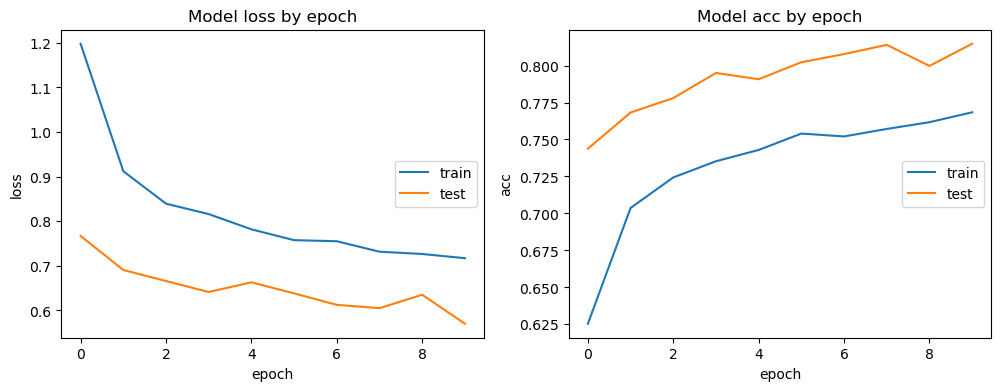

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model acc by epoch')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()


## Test prédictions 

On affiche les probabilités du champignon testé avec les 10 classes puis le nom de la classe choisie


In [18]:
#Récupération des classes
train_generator.get_classes(data_train, "genus")
labels = (train_generator.class_indices)
classes = dict((v,k) for k,v in labels.items())
#predictions = [labels[k] for k in predicted_class_indices]

./ChampImages/Phallales/Phallaceae/Clathrus/Clathrus columnatus/im276125.jpg


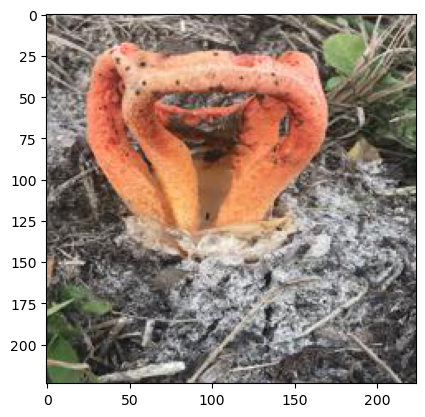

Probabilité pour les 10 classes : [[1.24013076e-24 1.00294344e-19 2.56956392e-24 1.31710640e-21
  1.00000000e+00 2.07760002e-21 7.24454341e-28 1.27099944e-22
  1.33039914e-18 3.23429692e-25]]
Classe présentie : Clathrus


In [20]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])

./ChampImages/Agaricales/Amanitaceae/Amanita/Amanita muscaria/im629728.jpg


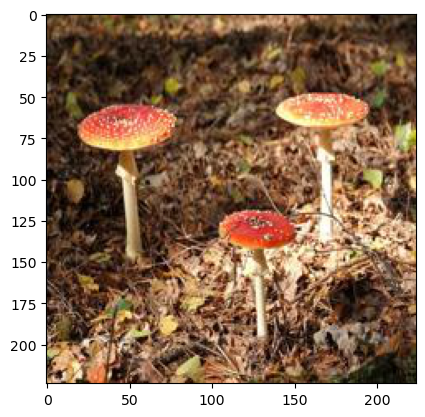

Probabilité pour les 10 classes : [[1.6788372e-10 1.0000000e+00 5.1327575e-30 2.3540113e-23 2.7705625e-23
  3.8347734e-19 5.2181708e-27 9.4096910e-17 5.9693035e-27 5.2970413e-23]]
Classe présentie : Amanita


In [21]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])

./ChampImages/Boletales/Sclerodermataceae/Scleroderma/Scleroderma citrinum/im93746.jpg


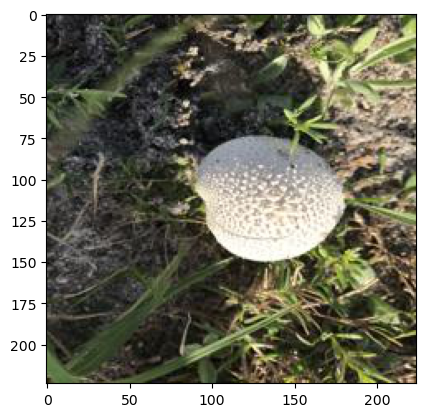

Probabilité pour les 10 classes : [[2.5166196e-03 3.2658622e-02 6.1294320e-12 2.6132185e-11 2.4698704e-10
  1.0026040e-09 3.6730154e-09 1.2843768e-09 1.2563812e-10 9.6482474e-01]]
Classe présentie : Scleroderma


In [23]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])

./ChampImages/Phallales/Phallaceae/Clathrus/Clathrus archeri/im1497352.jpg


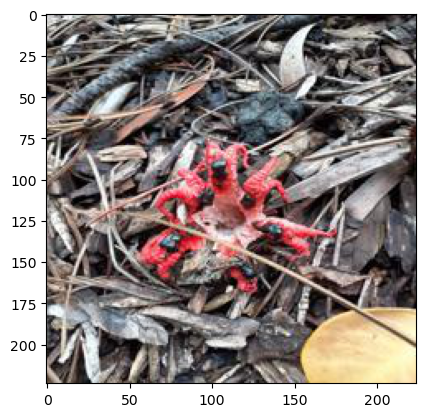

Probabilité pour les 10 classes : [[2.8620345e-15 1.9835693e-12 2.8646109e-16 1.2661812e-12 1.0000000e+00
  2.0451349e-11 1.2172506e-14 9.4714592e-12 8.8191103e-13 1.0328057e-13]]
Classe présentie : Clathrus


In [26]:
# Test prédiction, relancer la cellule plusieurs fois pour changer d'image
# Le chemin du fichier permet de vérifier le genre du champignon
# \genre\species\imxxxx.jpg

from tensorflow.keras.preprocessing import image
import numpy as np

filename = data_test.path.iloc[np.random.randint(len(data_test))]
print(filename)

img = image.load_img(filename,target_size=(224,224))
plt.imshow(img)
plt.show()

# Seconde solution de préprocessing
img = image.img_to_array(img)
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
img = preprocess_input(img)

output = model.predict(img)

print("Probabilité pour les 10 classes :", output)
print("Classe présentie :", classes[output.argmax()])